<div dir='ltr'><font face="B Zar" size=5>
Import Libraries
</font></div>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import *

<div dir='ltr'><font face="B Zar" size=5>
Load image by cv2 and convert it to RGB. then plot it via matlotlib library.
</font></div>

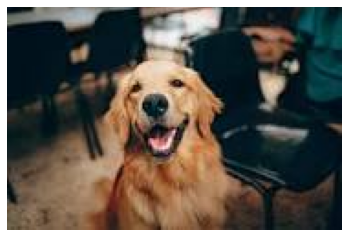

In [63]:
img=cv2.imread('dog.jpeg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [64]:
img.shape

(122, 183, 3)

<div dir='ltr'><font face="B Zar" size=5>
For Kernel Density 
</font></div>

In [83]:
def show_histogram(img,bins,is_rgb=True):
  
  if is_rgb:
    plt.figure(figsize=(30,18))
    plt.subplot(3,1,1)
    hist_red=np.histogram(img[:,:,0].ravel(),bins)
    plt.title('red histogrm',fontsize='20')
    plt.bar(np.linspace(0,255,bins),hist_red[0],color='r')

    plt.subplot(3,1,2)
    hist_green=np.histogram(img[:,:,1].ravel(),bins)
    plt.title('green histogrm',fontsize='20')
    plt.bar(np.linspace(0,255,bins),hist_green[0],color='g')

    plt.subplot(3,1,3)
    hist_blue=np.histogram(img[:,:,2].ravel(),bins)
    plt.title('blue histogrm',fontsize='20')
    plt.bar(np.linspace(0,255,bins),hist_blue[0],color='b')
    plt.show()
    return hist_red,hist_green,hist_blue
  if not is_rgb:
    plt.figure(figsize=(30,10))
    hist=np.histogram(cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY).ravel(),bins)
    plt.title('graylevel histogrm',fontsize='20')
    plt.bar(np.linspace(0,255,bins),hist[0],color='k')
    plt.show()
    return hist

  



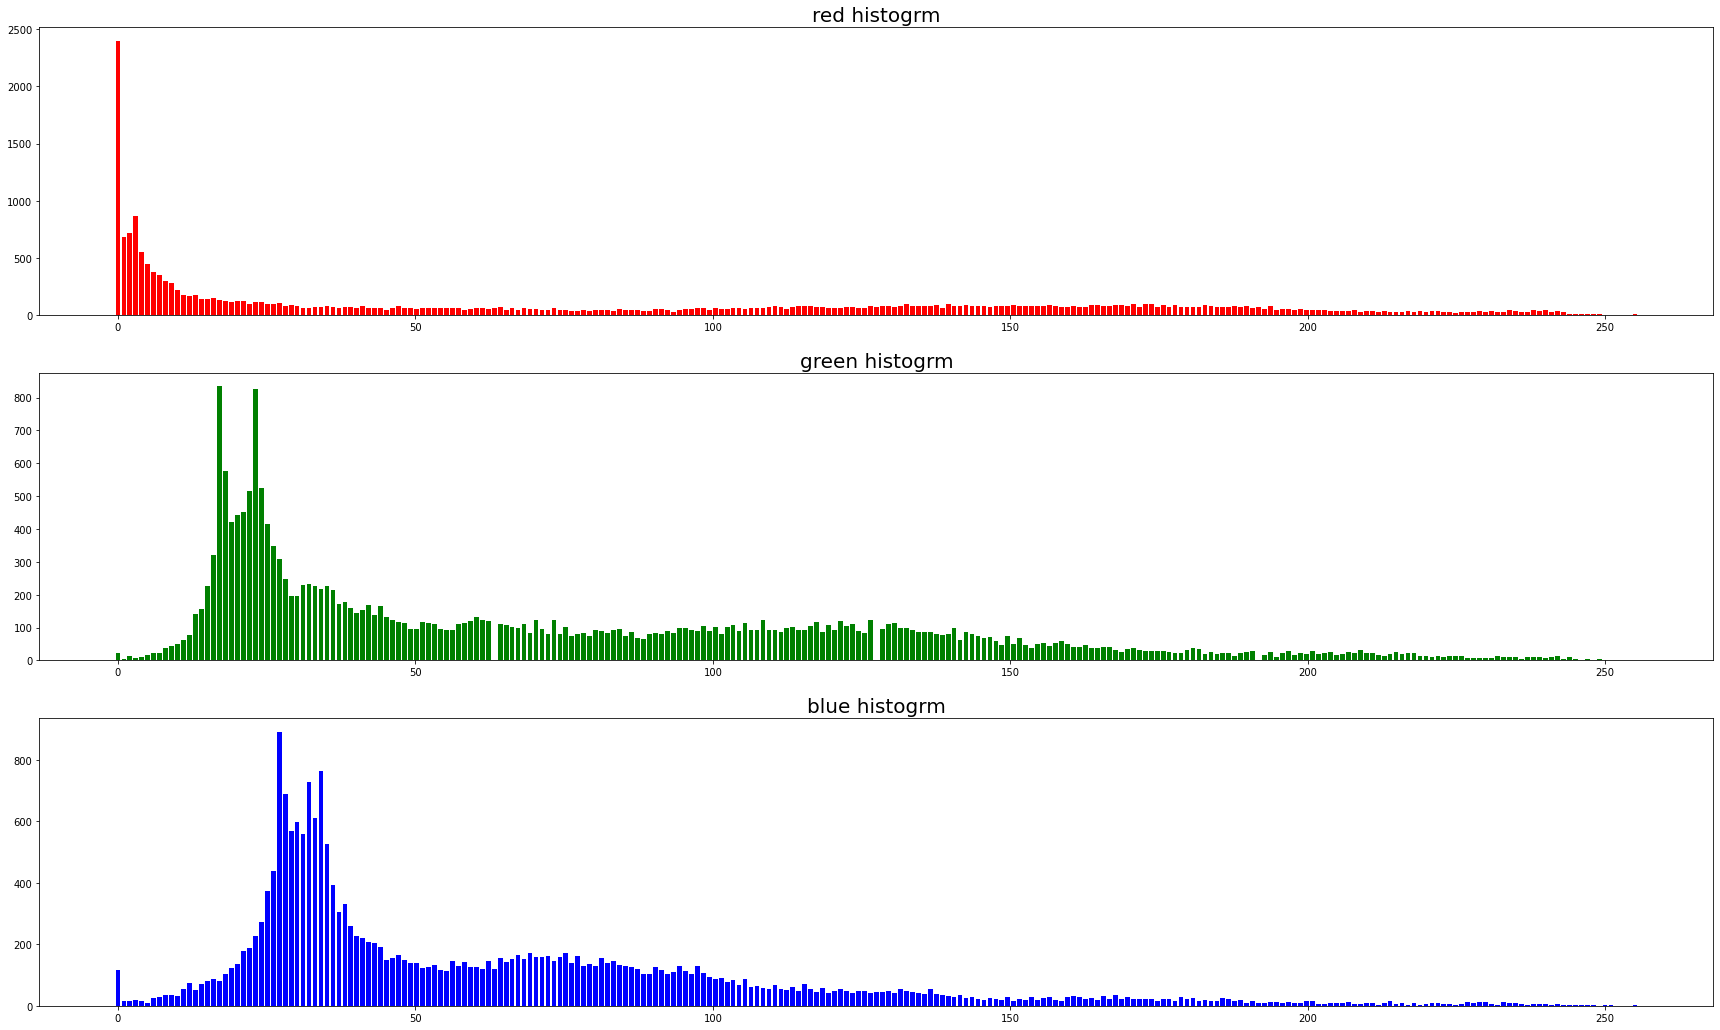

In [66]:
#rgb histaograms
r_hist,g_hist,b_hist=show_histogram(img,255,True)

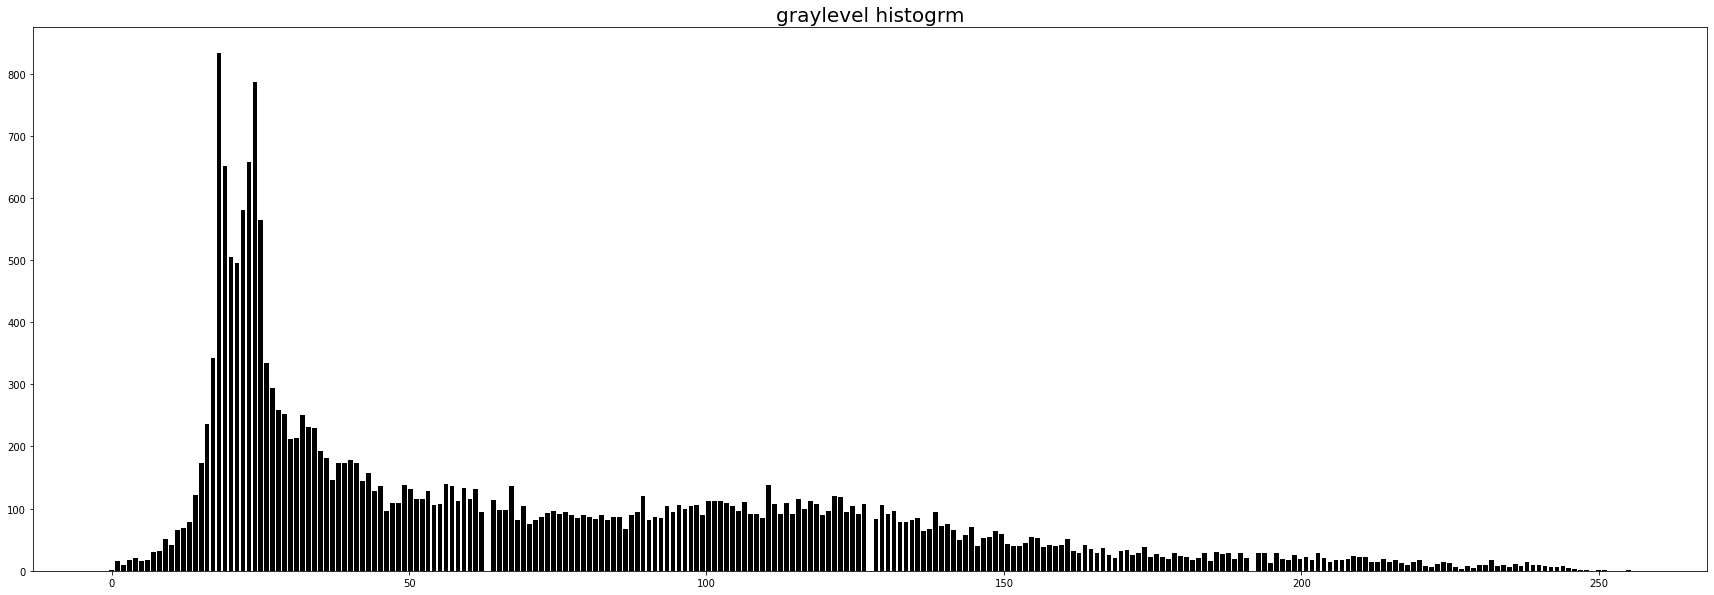

In [84]:
#gray level histogram
gray_hist=show_histogram(img,255,False)

In [68]:
def show_KDE_plot(data,title,color):
  plt.figure(figsize=(10,8))
  plt.title(title,fontsize='20')
  plt.plot(data,color=color)
  plt.show()

In [69]:
def KDE_Gaussian_Kernel(x,data,bandwith_h):
  # x is a single bin in histogram
  n=len(data)
  kde=0
  kde=(1/(sqrt(2*np.pi)*bandwith_h*n)) *np.sum((np.exp((-1/2)*np.power((x-data)/bandwith_h,2))))
  return kde

def kde(x,dataset , h ,n=255,bin=255):
   N = len(dataset)
   pdf = (1/(h*N)) * (1/np.sqrt(2*np.pi) * np.sum(np.exp(-((dataset-x)**2)/(2*(h**2)))))
   return pdf

In [76]:
def find_suitable_bandwith_h(data,n_bins):
  standard_dv=np.std(data)
  q1,q3=np.percentile(data,[25,75])
  iqr=q3-q1
  bandwith_h=0.9 * min(standard_dv,iqr/1.34) * pow(n_bins,-1/5)
  return bandwith_h

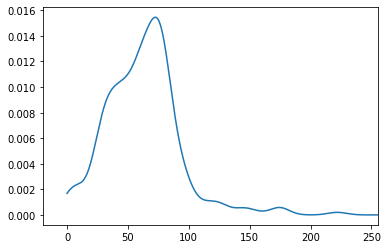

In [79]:
xvals = np.arange(0,255.1,0.1)
h_red=find_suitable_bandwith_h(r_hist[0],255)
kde_b = np.array([kde(x, r_hist[0],h_red) for x in xvals])
plt.plot(xvals, (kde_b))
plt.xlim(-20,255)
plt.show()

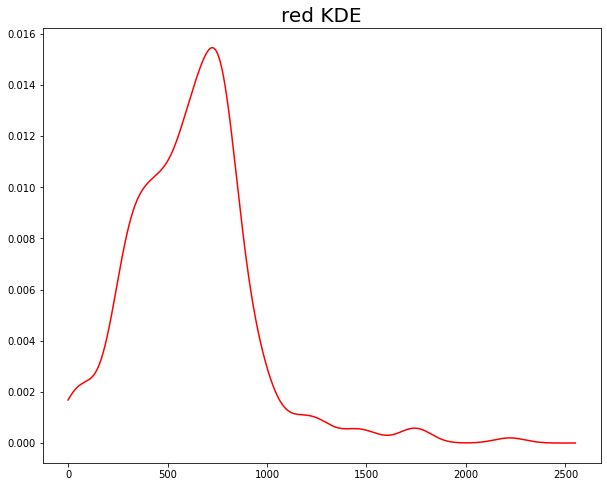

In [78]:
xdim_kde = np.arange(0,255.1,0.1)

# KDE on red
h_red=find_suitable_bandwith_h(r_hist[0],255)
red_kde_out = np.array([KDE_Gaussian_Kernel(x,r_hist[0],h_red) for x in xdim_kde])
show_KDE_plot(red_kde_out,'red KDE','r')

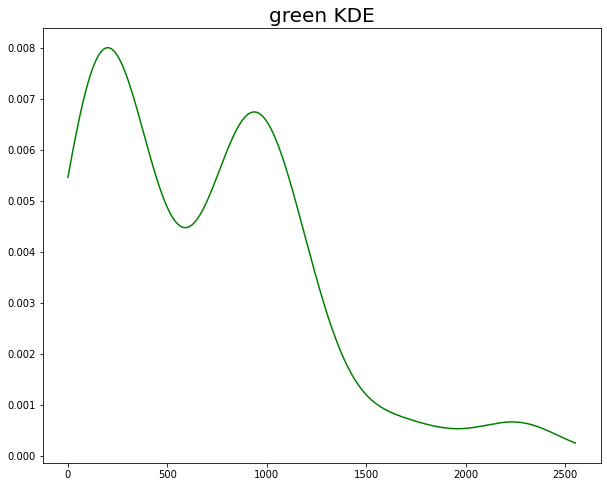

In [80]:
# KDE on green
h_green=find_suitable_bandwith_h(g_hist[0],255)
green_kde_out = np.array([KDE_Gaussian_Kernel(x,g_hist[0],h_green) for x in xdim_kde])
show_KDE_plot(green_kde_out,'green KDE','g')

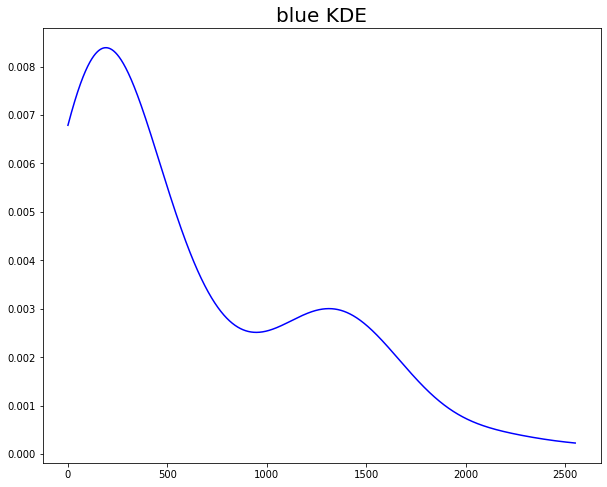

In [81]:
# KDE on blue
h_blue=find_suitable_bandwith_h(b_hist[0],255)
blue_kde_out = np.array([KDE_Gaussian_Kernel(x,b_hist[0],h_blue) for x in xdim_kde])
show_KDE_plot(blue_kde_out,'blue KDE','b')

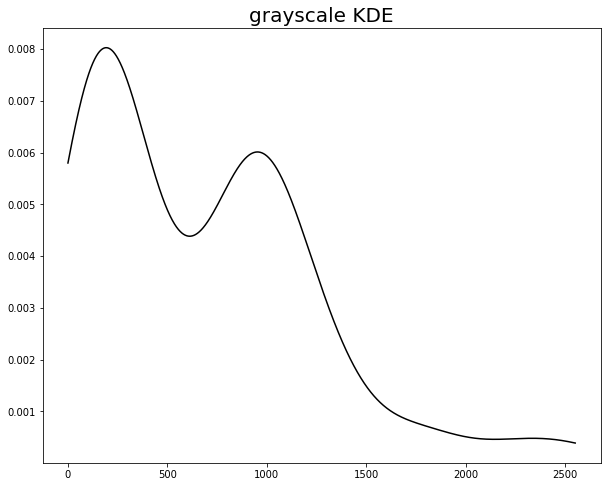

In [86]:
# KDE on grayscale
h_gray=find_suitable_bandwith_h(gray_hist[0],255)
grayscale_kde_out = np.array([KDE_Gaussian_Kernel(x,gray_hist[0],h_gray) for x in xdim_kde])
show_KDE_plot(grayscale_kde_out,'grayscale KDE','k')

In [93]:
def build_cluster_suitable_dtst(x_dim,r_kde,g_kde,b_kde,gray_kde):
  red=np.column_stack([x_dim, r_kde])
  green=np.column_stack([x_dim, g_kde])
  blue=np.column_stack([x_dim, b_kde])
  gray=np.column_stack([x_dim, gray_kde])
  return red,green,blue,gray

In [95]:
# build suitable datasets for meanshift (2D datasets for red green blue channels and also graysacle)
red_dst,green_dst,blue_dst,grayscale_dst = build_cluster_suitable_dtst(xdim_kde,red_kde_out,green_kde_out,blue_kde_out,grayscale_kde_out)
grayscale_dst.shape

(2551, 2)

In [97]:
STOP_THRESHOLD = 1e-4
CLUSTER_THRESHOLD = 1e-1

def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def gaussian_kernel(distance, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth)) ** 2)

class MeanShift(object):
    def __init__(self, kernel=gaussian_kernel):
        self.kernel = kernel

    def fit(self, points, kernel_bandwidth):

        shift_points = np.array(points)
        shifting = [True] * points.shape[0]

        while True:
            max_dist = 0
            for i in range(0, len(shift_points)):
                if not shifting[i]:
                    continue
                p_shift_init = shift_points[i].copy()
                shift_points[i] = self._shift_point(shift_points[i], points, kernel_bandwidth)
                dist = distance(shift_points[i], p_shift_init)
                max_dist = max(max_dist, dist)
                shifting[i] = dist > STOP_THRESHOLD

            if(max_dist < STOP_THRESHOLD):
                break
        cluster_ids = self._cluster_points(shift_points.tolist())
        return shift_points, cluster_ids

    def _shift_point(self, point, points, kernel_bandwidth):
        shift_x = 0.0
        shift_y = 0.0
        scale = 0.0
        for p in points:
            dist = distance(point, p)
            weight = self.kernel(dist, kernel_bandwidth)
            shift_x += p[0] * weight
            shift_y += p[1] * weight
            scale += weight
        shift_x = shift_x / scale
        shift_y = shift_y / scale
        return [shift_x, shift_y]

    def _cluster_points(self, points):
        cluster_ids = []
        cluster_idx = 0
        cluster_centers = []

        for i, point in enumerate(points):
            if(len(cluster_ids) == 0):
                cluster_ids.append(cluster_idx)
                cluster_centers.append(point)
                cluster_idx += 1
            else:
                for center in cluster_centers:
                    dist = distance(point, center)
                    if(dist < CLUSTER_THRESHOLD):
                        cluster_ids.append(cluster_centers.index(center))
                if(len(cluster_ids) < i + 1):
                    cluster_ids.append(cluster_idx)
                    cluster_centers.append(point)
                    cluster_idx += 1
        return cluster_ids



In [98]:

mean_shifter = MeanShift()
shift_points, cluster_ids = mean_shifter.fit(red_dst, kernel_bandwidth=h_red)





KeyboardInterrupt: ignored